In [1]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold
import tensorflow as tf
# tf.compat.v1.enable_eager_execution(
#     config=None, device_policy=None, execution_mode=None
# )

In [2]:
DATA_DIR = Path(r'c:\\Users\\HP\\Documents\\GitHub\\Mask_RCNN\\fashion_dataset')
ROOT_DIR = Path(r'c:\\Users\\HP\\Documents\\GitHub\\Mask_RCNN')

In [3]:
sys.path.append(r'c:\\Users\\HP\\Documents\\GitHub\\Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils_for_FGC
import mrcnn.model_for_FGC as modellib
from mrcnn import visualize
from mrcnn.model_for_FGC import log

Using TensorFlow backend.


In [4]:
COCO_WEIGHTS_PATH = r'c:\\Users\\HP\\Documents\\GitHub\\Mask_RCNN\\mask_rcnn_coco.h5'
NUM_CATS = 46
IMAGE_SIZE = 1024

In [5]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 # a memory error occurs when IMAGES_PER_GPU is too high
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200

    ## My changes CA
    BACKBONE = 'resnet101'
    
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024    
    IMAGE_RESIZE_MODE = 'square'

    MINI_MASK_SHAPE = (112, 112)  # (height, width) of the mini-mask

    NUM_ATTR = 294

    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.,
        "rpn_bbox_loss": 1.,
        "mrcnn_class_loss": 1.,
        "mrcnn_bbox_loss": 1.,
        "mrcnn_mask_loss": 1.,
        "mrcnn_attr_loss":1.
    }


    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_attr_loss': 1.0}
MASK_POOL_SIZE              

In [6]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

class_names = [x['name'] for x in label_descriptions['categories']]
attr_names = [x['name'] for x in label_descriptions['attributes']]

In [7]:
print(len(class_names),len(attr_names))

46 294


In [8]:
segment_df = pd.read_csv(DATA_DIR/"train_small.csv")
segment_df['AttributesIds'] = segment_df['AttributesIds'].apply(lambda x:tuple([int(i) for i in x.split(',')]))

In [9]:
def pad_tuple_attrs(x):
    if x!=x:
        x = []
    else:
        x = list(x)
    for i in range(10):
        if(i>=len(x)):
            x.append(-1)
        if x[i]>=281 and x[i]<284:
            x[i] = x[i]-46
        elif x[i]>284:
            x[i] = x[i]-47
    
    x = tuple(x)
    return x


In [10]:
segment_df['AttributesIds'] = segment_df['AttributesIds'].apply(pad_tuple_attrs)

In [11]:
segment_df['AttributesIds'].head()

0    (115, 136, 143, 154, 230, 248, 269, 270, -1, -1)
1    (115, 136, 142, 146, 225, 248, 269, 270, -1, -1)
2           (163, -1, -1, -1, -1, -1, -1, -1, -1, -1)
3          (160, 204, -1, -1, -1, -1, -1, -1, -1, -1)
4           (219, -1, -1, -1, -1, -1, -1, -1, -1, -1)
Name: AttributesIds, dtype: object

In [12]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'ClassId', 'AttributesIds'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  20


,EncodedPixels,ClassId,AttributesIds,Height,Width
ImageId,,,,,
00000663ed1ff0c4e0132b9b9ac53f6e,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]","[(115, 136, 143, 154, 230, 248, 269, 270, -1, ...",5214,3676
000aac3870ea7c59ca0333ffa5327323,[8971124 17 8975101 49 8979077 82 8983053 116 ...,"[10, 33, 3, 31, 31, 33]","[(104, 115, 129, 145, 149, 248, 261, 278, -1, ...",4000,6000
00102686c01fa625aba3b2478f48f415,[1030495 6 1032230 18 1033965 30 1035701 41 10...,"[31, 31, 33, 10]","[(160, -1, -1, -1, -1, -1, -1, -1, -1, -1), (1...",1742,1500
0017af9f7fa8ce9e7558bb924cec324e,[169688 9 171477 25 173265 43 175053 60 176841...,"[6, 1, 31, 31, 33]","[(38, 115, 135, 142, 154, 234, 248, 254, 270, ...",1797,607
0055347a114b215f8f469fec9e38c272,[893062 1 894561 4 896061 7 897560 10 899059 1...,"[33, 31, 10]","[(182, -1, -1, -1, -1, -1, -1, -1, -1, -1), (1...",1500,1000


In [13]:
c = segment_df.iloc[0]['EncodedPixels']
# c= c.split(',')
print(type(c))

<class 'str'>


In [14]:
def resize_image(image_path):
    image_path = image_path + ".jpg"
    # print("image_path", image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [15]:
class FashionDataset(utils_for_FGC.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(class_names):
            self.add_class("fashion", i+1, name)
        
        for i, name in enumerate(attr_names):
            self.add_attribute("fashion", i, name)
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name), 
                           labels=row['ClassId'],
                           attributes=row['AttributesIds'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    

    def image_reference(self, image_id):
        attr_sublist=[]
        attr_list=[]
        info = self.image_info[image_id]
        for x in info['attributes']:
            for j in x:
                if(j>234):
                    j=j-46
                
                attr_sublist.append(attr_names[int(j)])
            attr_list.append(attr_sublist)
            
        return info['path'], [class_names[int(x)] for x in info['labels']],attr_list
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        attributes = []
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            attributes.append(list(info['attributes'][m]))
            
        return mask, np.array(labels), np.array([np.array(attr) for attr in attributes])

('c:\\Users\\HP\\Documents\\GitHub\\Mask_RCNN\\fashion_dataset\\train\\02cc3d7cf83d7a6d39b73a73ec4214b5', ['dress', 'sleeve', 'sleeve', 'neckline'], [['shift (dress)', 'pencil', 'mini (length)', 'no opening', 'off-the-shoulder', 'curved (pocket)', 'plastic', 'plant', 'plant', 'plant', 'wrist-length', 'set-in sleeve', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'wrist-length', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'off-the-shoulder', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant'], ['shift (dress)', 'pencil', 'mini (length)', 'no opening', 'off-the-shoulder', 'curved (pocket)', 'plastic', 'plant', 'plant', 'plant', 'wrist-length', 'set-in sleeve', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'wrist-length', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant', 'off-the-shoulder', 'plant', 'plant', 'plant', 'plant', 'plant', 'plant'

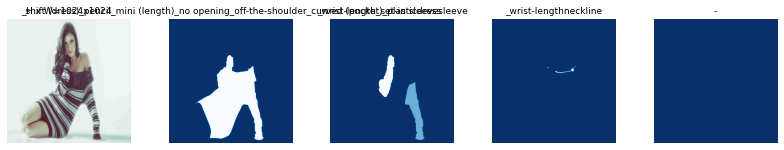

In [16]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(1):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids, attr_ids = dataset.load_mask(image_id)
    # print("class_ids", class_ids)
    # print("attr_ids", attr_ids)
    # print(type(attr_ids))
    visualize.display_top_masks(image, mask, class_ids, attr_ids, dataset.class_names, dataset.attr_names, limit=4)

In [17]:
# This code partially supports k-fold training, 
# you can specify the fold to train and the total number of folds here
FOLD = 0
N_FOLDS = 3

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Total train images:  13
Total train segments:  47


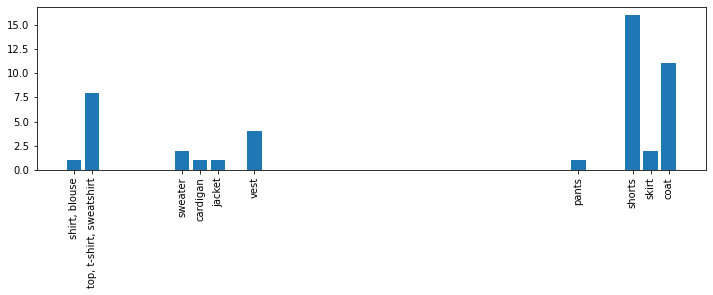

Total train images:  7
Total validation segments:  27


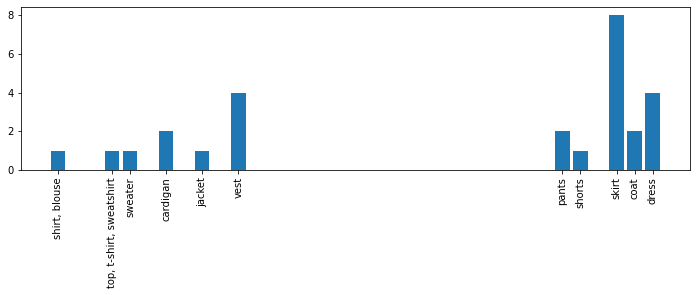

Total train segments:  169


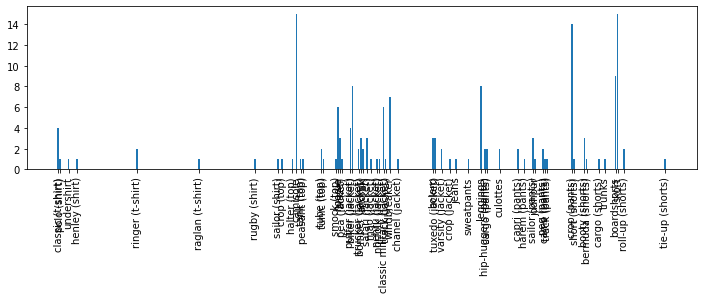

Total train segments:  99


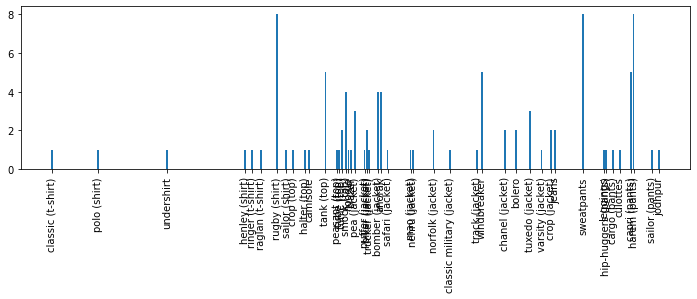

In [18]:
train_segments = np.concatenate(train_df['ClassId'].values).astype(int)
print("Total train images: ", len(train_df))
print("Total train segments: ", len(train_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, class_names, rotation='vertical')
plt.show()

valid_segments = np.concatenate(valid_df['ClassId'].values).astype(int)
print("Total train images: ", len(valid_df))
print("Total validation segments: ", len(valid_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, class_names, rotation='vertical')
plt.show()


train2_segments = np.concatenate(train_df['AttributesIds'].values).astype(int).reshape((-1,))
train2_segments = train2_segments[train2_segments!= -1]
# print("Total train images: ", len(valid_df))
print("Total train segments: ", len(train2_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train2_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, attr_names, rotation='vertical')
plt.show()

train2_segments = np.concatenate(valid_df['AttributesIds'].values).astype(int).reshape((-1,))
train2_segments = train2_segments[train2_segments!= -1]
# print("Total train images: ", len(valid_df))
print("Total train segments: ", len(train2_segments))

plt.figure(figsize=(12, 3))
values, counts = np.unique(train2_segments, return_counts=True)
plt.bar(values, counts)
plt.xticks(values, attr_names, rotation='vertical')
plt.show()




In [19]:
import warnings 
warnings.filterwarnings("ignore")

In [20]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead
Tensor("proposal_targets/target_bbox:0", shape=(2, ?, 4), dtype=float32)
Tensor("proposal_targets/target_attr_ids:0", shape=(2, ?, 10), dtype=int32)


In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

In [22]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE*2, # train heads with higher lr to speedup learning
            epochs=2,
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: c:\Users\HP\Documents\GitHub\Mask_RCNN\fashion20200422T1754\mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribut

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 8 array(s), but instead got the following list of 7 arrays: [array([[[[-115.7, -108.8,  -95.9],
         [-115.7, -108.8,  -95.9],
         [-119.7, -112.8,  -99.9],
         ...,
         [ -85.7,  -59.8,  -31.9],
         [ -85.7,  -59.8,  -31.9],
         [...

In [24]:
import tensorflow as tf 
print(tf.__version__)

1.14.0
